In [3]:
#Import required libraries
import pyodbc # SQL library
import pandas as pd # Dataframes
import numpy as np # Arrays
import matplotlib.pyplot as plt #Graphs
from datetime import date
import ydata_profiling
import plotly.offline as po
import plotly.graph_objs as go
%matplotlib inline
plt.style.use('ggplot') #gglot style
import seaborn as sns #Enhanced plot library
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler # To scale data
from sklearn.cluster import KMeans #K-means clustering
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split  # To randomly split the dataset
### from xverse.transformer import WOE # To perform Weight of Evidence for feature selection
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.metrics import accuracy_score # Accuracy for model assessment
from sklearn.feature_selection import RFE # Recursive Feature Elimination 
from sklearn.linear_model import LogisticRegression #Logistic Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier #Extra Trees
from sklearn.feature_selection import SelectKBest, chi2 # K best and Chi squre
from sklearn.svm import LinearSVC #Linear SVC for L1 featrue selection 
from sklearn.feature_selection import SelectFromModel #L1 feature selection 
from functools import reduce # To merge dataframes
from statsmodels.stats.outliers_influence import variance_inflation_factor #Multicollinearity check
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.ensemble import GradientBoostingClassifier #Gradient Boosting
from sklearn.metrics import fbeta_score #fbeta score for model assessment
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #LDA
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.neural_network import MLPClassifier #Newral Network
from sklearn.naive_bayes import GaussianNB # Naive Bayes
from sklearn.preprocessing import MinMaxScaler #To scale data for SVC
from sklearn.svm import SVC #Support Vector Machine
from sklearn.model_selection import validation_curve, StratifiedKFold,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report # For model evaluation 
import joblib
#from sklearn.externals import joblib # To save the final model
import mlxtend as ml #Market Basket Analysis
from mlxtend.frequent_patterns import apriori # To extract frequent itemsets for MBA
from mlxtend.frequent_patterns import association_rules # To create the MBA rules
from datetime import timedelta #To define potential churn date
from warnings import simplefilter #Warning filter
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, classification_report


In [4]:
# iGNORING THE WARNINGS
#import sys

#if not sys.warnoptions:
 #   import warnings
  #  warnings.simplefilter("ignore")

In [5]:
#Connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-P46BCFH;'
                      'Database=WideWorldImporters;'
                      'Trust_Connection= yes;')


In [6]:
#SQL query; Transactional data
data=pd.read_sql_query("""SELECT 
                                [P].[StateProvinceID],
                                [O].[OrderDate],
                                [P].[StateProvinceName] AS _State,
                                [SG].[StockGroupName] AS Product_Cat,
                                [SG].[StockGroupID] AS Product_CatID,
                                COUNT(OL.StockItemID) AS Demand
                                FROM [Sales].[Customers] C
                                JOIN [Sales].[Invoices] S ON [C].[CustomerID] = [S].[CustomerID]
                                JOIN [Sales].[Orders] O ON [S].[CustomerID] = [O].[CustomerID]
                                JOIN [Sales].[OrderLines] OL ON [S].[OrderID] = OL.[OrderID]
                                JOIN [Application].[Cities] R ON [C].[DeliveryCityID] = [R].[CityID]
                                JOIN [Application].[StateProvinces] P on [R].[StateProvinceID] = [P].[StateProvinceID]
                                JOIN [Warehouse].[StockItemStockGroups] SIS on [OL].[StockItemID] = [SIS].[StockItemID]
                                JOIN [Warehouse].[StockGroups] SG on [SIS].[StockGroupID] = [SG].[StockGroupID]
                                GROUP BY [SG].[StockGroupName], [P].[StateProvinceName], [O].[OrderDate],[P].[StateProvinceID],[SG].[StockGroupID]
                                Having [O].[OrderDate] >= DATEADD(YEAR, -3, MAX([O].[OrderDate]))
                                ORDER BY Demand DESC; """, conn)

conn.close()

C:\Users\USER\AppData\Local\Temp\ipykernel_12844\3781075793.py:2: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



### Data pre-processing


In [7]:
data.head()

,StateProvinceID,OrderDate,_State,Product_Cat,Product_CatID,Demand
0,45,2013-11-06,Texas,Novelty Items,1,2440
1,45,2013-11-06,Texas,Computing Novelties,6,2401
2,45,2015-10-19,Texas,Novelty Items,1,2209
3,45,2014-04-23,Texas,Novelty Items,1,2204
4,45,2015-04-23,Texas,Novelty Items,1,2187


In [8]:
data.shape

(292381, 6)

In [9]:
#Overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292381 entries, 0 to 292380
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   StateProvinceID  292381 non-null  int64 
 1   OrderDate        292381 non-null  object
 2   _State           292381 non-null  object
 3   Product_Cat      292381 non-null  object
 4   Product_CatID    292381 non-null  int64 
 5   Demand           292381 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 13.4+ MB


In [10]:
data.Demand.describe() #basis statistics

count    292381.000000
mean        176.867584
std         178.973830
min           1.000000
25%          63.000000
50%         121.000000
75%         232.000000
max        2440.000000
Name: Demand, dtype: float64

### Demand Classification

In [11]:
data["HighOLow"] = data.Demand.map(lambda val: 0 if val <= 121  else 1)

#High demand region = 1 , low demand region = 0

In [12]:
data.head()

,StateProvinceID,OrderDate,_State,Product_Cat,Product_CatID,Demand,HighOLow
0,45,2013-11-06,Texas,Novelty Items,1,2440,1
1,45,2013-11-06,Texas,Computing Novelties,6,2401,1
2,45,2015-10-19,Texas,Novelty Items,1,2209,1
3,45,2014-04-23,Texas,Novelty Items,1,2204,1
4,45,2015-04-23,Texas,Novelty Items,1,2187,1


In [13]:
#Checking for potential duplicate rows
print('Number of duplicates:', data.duplicated().sum())

Number of duplicates: 0


In [14]:
data.columns

Index(['StateProvinceID', 'OrderDate', '_State', 'Product_Cat',
       'Product_CatID', 'Demand', 'HighOLow'],
      dtype='object')

In [15]:
data.isnull().sum()

StateProvinceID    0
OrderDate          0
_State             0
Product_Cat        0
Product_CatID      0
Demand             0
HighOLow           0
dtype: int64

### Feature Engineering/Data Wrangling

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292381 entries, 0 to 292380
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   StateProvinceID  292381 non-null  int64 
 1   OrderDate        292381 non-null  object
 2   _State           292381 non-null  object
 3   Product_Cat      292381 non-null  object
 4   Product_CatID    292381 non-null  int64 
 5   Demand           292381 non-null  int64 
 6   HighOLow         292381 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 15.6+ MB


In [17]:
data.rename({'_State': 'Region'},
                   axis=1, inplace=True)

In [18]:
data.head()

,StateProvinceID,OrderDate,Region,Product_Cat,Product_CatID,Demand,HighOLow
0,45,2013-11-06,Texas,Novelty Items,1,2440,1
1,45,2013-11-06,Texas,Computing Novelties,6,2401,1
2,45,2015-10-19,Texas,Novelty Items,1,2209,1
3,45,2014-04-23,Texas,Novelty Items,1,2204,1
4,45,2015-04-23,Texas,Novelty Items,1,2187,1


In [19]:
data.drop(['Product_CatID','OrderDate'], axis=1, inplace=True)

In [20]:
data.head()

,StateProvinceID,Region,Product_Cat,Demand,HighOLow
0,45,Texas,Novelty Items,2440,1
1,45,Texas,Computing Novelties,2401,1
2,45,Texas,Novelty Items,2209,1
3,45,Texas,Novelty Items,2204,1
4,45,Texas,Novelty Items,2187,1


In [21]:
data_copy=data.copy()

In [22]:
data_copy.drop('StateProvinceID', axis=1, inplace=True)

In [23]:
data_copy.head()

,Region,Product_Cat,Demand,HighOLow
0,Texas,Novelty Items,2440,1
1,Texas,Computing Novelties,2401,1
2,Texas,Novelty Items,2209,1
3,Texas,Novelty Items,2204,1
4,Texas,Novelty Items,2187,1


C:\Users\USER\AppData\Local\Temp\ipykernel_12844\3025026007.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




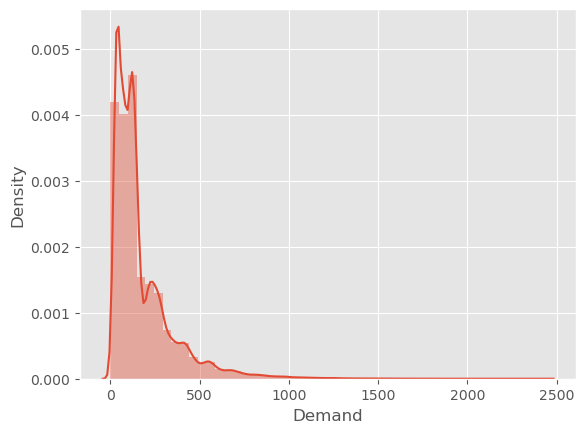

In [24]:
x = data_copy['Demand']

ax = sns.distplot(x)

In [25]:
data_copy['Demand']=np.log(data_copy['Demand'])

C:\Users\USER\AppData\Local\Temp\ipykernel_12844\3025026007.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




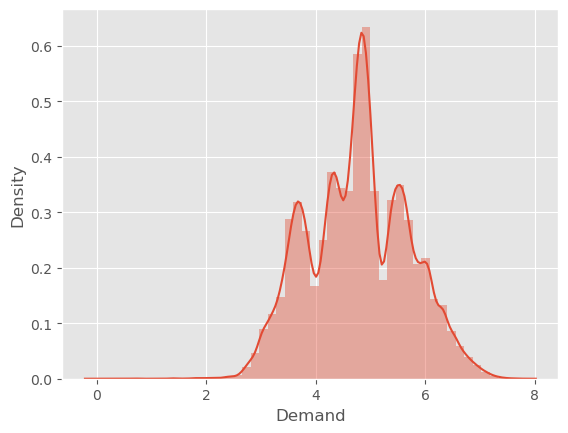

In [26]:
x = data_copy['Demand']

ax = sns.distplot(x)

In [27]:
data_copy.head()

,Region,Product_Cat,Demand,HighOLow
0,Texas,Novelty Items,7.799753,1
1,Texas,Computing Novelties,7.783641,1
2,Texas,Novelty Items,7.700295,1
3,Texas,Novelty Items,7.698029,1
4,Texas,Novelty Items,7.690286,1


In [28]:
#Data encoding

In [29]:
cols = ['Region','Product_Cat']
data_copy = pd.get_dummies(data=data_copy, columns = cols)

In [28]:
data_copy.head()

,Demand,HighOLow,Region_Alabama,Region_Alaska,Region_Arizona,Region_Arkansas,Region_California,Region_Colorado,Region_Connecticut,Region_Florida,...,Region_Wyoming,Product_Cat_Clothing,Product_Cat_Computing Novelties,Product_Cat_Furry Footwear,Product_Cat_Mugs,Product_Cat_Novelty Items,Product_Cat_Packaging Materials,Product_Cat_T-Shirts,Product_Cat_Toys,Product_Cat_USB Novelties
0,7.799753,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,7.783641,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,7.700295,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,7.698029,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,7.690286,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [29]:
HighDemand=data_copy[data_copy['HighOLow']==1]

In [30]:
HighDemand.HighOLow.value_counts()

1    144904
Name: HighOLow, dtype: int64

In [31]:
LowDemand = data_copy[data_copy['HighOLow']==0]

In [32]:
LowDemand.HighOLow.value_counts()

0    147477
Name: HighOLow, dtype: int64

###  Model Development


### Traning/test split/harness

In [33]:
X = data_copy.loc[:, data_copy.columns != "HighOLow"]

In [34]:
data_copy

,Demand,HighOLow,Region_Alabama,Region_Alaska,Region_Arizona,Region_Arkansas,Region_California,Region_Colorado,Region_Connecticut,Region_Florida,...,Region_Wyoming,Product_Cat_Clothing,Product_Cat_Computing Novelties,Product_Cat_Furry Footwear,Product_Cat_Mugs,Product_Cat_Novelty Items,Product_Cat_Packaging Materials,Product_Cat_T-Shirts,Product_Cat_Toys,Product_Cat_USB Novelties
0,7.799753,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,7.783641,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,7.700295,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,7.698029,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,7.690286,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292376,0.693147,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
292377,0.693147,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
292378,0.693147,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
292379,0.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [35]:
y = data_copy['HighOLow']

In [36]:
RANDOM_STATE=100

In [37]:
# b) apply a 50/50 split into training and test sets(using train_test_split)
#using train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.5,
                                                    random_state=RANDOM_STATE)

Fit model - (Logistic Regression)

we use the Logistic Regression algorithm first to fit to our TRAINING data.

We train the model on ALL the features

In [38]:
# STEP 1: set up a machine learning algorithm
estimator = LogisticRegression(random_state = RANDOM_STATE)

#STEP 2: fit the model to the TRAINING set
estimator.fit(X_train, y_train)

#STEP 3: predict using the TEST set FEATURES
y_pred = estimator.predict(X_test)

#optional: extract classification probabilities for later performance metrics
#y_score = estimator.predict_proba(X_test)[:0]

C:\Users\ISAAC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [39]:
y_true = y_test # variable name change(convention) 
#for reporting metrics below

In [40]:
accuracy_score(y_true, y_pred)

0.9974211818785014

In [41]:
precision_score(y_true, y_pred)

0.9979274897756162

In [42]:
# d) display recall and precision
recall_score(y_true, y_pred)

0.9968669344264558

In [43]:
# b) display confusion matrix results
confusion_matrix(y_true, y_pred)

array([[73588,   150],
       [  227, 72226]], dtype=int64)

C:\Users\ISAAC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



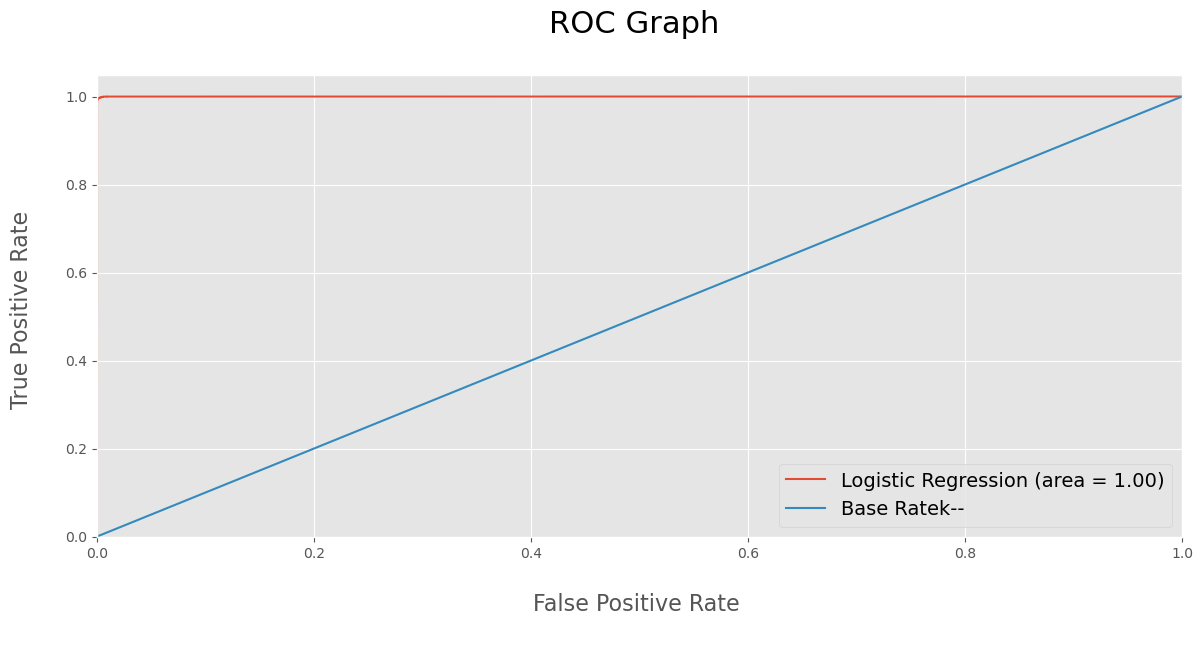

In [44]:
estimator.fit(X_train, y_train) 
probs = estimator.predict_proba(X_test) 
probs = probs[:, 1] 
estimator_roc_auc = accuracy_score(y_test, y_pred )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, estimator.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))
# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr, 
label='Logistic Regression (area = %0.2f)' % estimator_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "16", 
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "16", 
fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center", 
fontstyle = "normal", fontsize = "22", 
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "14")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

### Determining the Region Demand propensity

In [47]:
lr_classifier = LogisticRegression(random_state =100)
lr_classifier.fit(X_train, y_train)
# Predict the Test set results
yt_pred = lr_classifier.predict(X_test)
#probability score
y_pred_probs = lr_classifier.predict_proba(X_test)
y_pred_probs  = y_pred_probs [:, 1]

C:\Users\ISAAC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [48]:
y_pred_probs

array([2.29743317e-44, 9.99692126e-01, 1.00000000e+00, ...,
       7.43077375e-29, 1.04153681e-04, 2.00550338e-27])

In [49]:
X_test['StateProvinceID']=data['StateProvinceID']
y_test['StateProvinceID']=data['StateProvinceID']

In [51]:
test_identity = X_test['StateProvinceID']

In [68]:
final_results = pd.concat([test_identity, y_test], axis = 1).dropna()
final_results['predictions'] = yt_pred
final_results["propensity_High_Demand(%)"] = y_pred_probs
final_results["propensity_High_Demand(%)"] = final_results["propensity_High_Demand(%)"]*100
final_results["propensity_High_Demand(%)"]=final_results["propensity_High_Demand(%)"].round(2)
final_results = final_results[['StateProvinceID','HighOLow','predictions', 'propensity_High_Demand(%)']]
#final_results ['Ranking'] = pd.qcut(final_results['propensity_High_Demand(%)'].rank(method = 'first'),10,labels=range(10,0,-1))
final_results.head(20)

,StateProvinceID,HighOLow,predictions,propensity_High_Demand(%)
287059,3.0,0,0,0.00
116915,32.0,1,1,99.97
19151,21.0,1,1,100.00
5057,39.0,1,1,100.00
10058,14.0,1,1,100.00
158188,34.0,0,0,1.51
98875,3.0,1,1,100.00
61879,46.0,1,1,100.00
235298,17.0,0,0,0.00
18928,15.0,1,1,100.00


In [71]:
final_results['Region']=data['Region']

In [72]:
final_results.head(10)

,StateProvinceID,HighOLow,predictions,propensity_High_Demand(%),Region
287059,3.0,0,0,0.00,Arizona
116915,32.0,1,1,99.97,New Mexico
19151,21.0,1,1,100.00,Maryland
5057,39.0,1,1,100.00,Pennsylvania
10058,14.0,1,1,100.00,Illinois
158188,34.0,0,0,1.51,North Carolina
98875,3.0,1,1,100.00,Arizona
61879,46.0,1,1,100.00,Utah
235298,17.0,0,0,0.00,Kansas
18928,15.0,1,1,100.00,Indiana


In [58]:
HighDemandRegion=final_results[final_results['predictions']==1]

In [59]:
HighDemandRegion.Region.value_counts()

Texas                         3697
Pennsylvania                  3334
California                    3319
New York                      3057
Ohio                          2390
Florida                       2390
Minnesota                     2116
New Jersey                    2111
Missouri                      2049
Illinois                      2018
New Mexico                    1917
Colorado                      1917
North Carolina                1859
Oklahoma                      1816
Washington                    1766
Alabama                       1680
West Virginia                 1647
Louisiana                     1601
Kansas                        1586
South Carolina                1574
Iowa                          1549
Indiana                       1546
Wisconsin                     1470
Georgia                       1422
Michigan                      1415
Arizona                       1360
Alaska                        1344
North Dakota                  1291
Kentucky            

In [60]:
top_10 = (final_results['Region'].value_counts()).iloc[:10]

In [63]:
top_10

Texas           4629
Pennsylvania    4548
California      4526
New York        4406
Florida         4045
Ohio            4004
Minnesota       3898
New Jersey      3889
Illinois        3809
Missouri        3809
Name: Region, dtype: int64

Text(0, 0.5, 'Ordered Quantity')

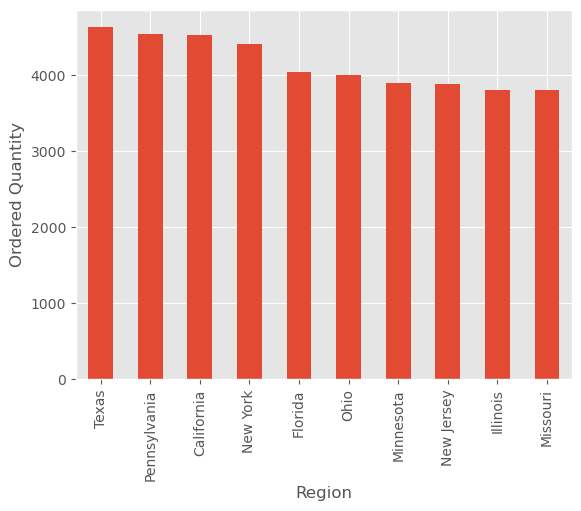

In [64]:
top_10.plot(kind='bar')
plt.rcParams['font.size'] = 20
plt.xlabel("Region")
plt.ylabel("Ordered Quantity")